In [52]:
import os
import sys
import itertools
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec
from matplotlib.collections import LineCollection

sys.path.append(os.path.expanduser('~/Documents/telegates'))
from telegates.processing import regions, regions2, selectregion, spatial_mean, agg_time, deseasonalize, lag_precursor, makeindex, makeindex2, create_response, combine_index_response
from telegates.subsetting import digitize, count_combinations, split, split_compute, split_index
from telegates.utils import interpolate, select_months

eradir = Path(os.path.expanduser('~/ERA5/'))

### Sst index, spatially & through time 

In [17]:
timeagg = 21
separation = -15
basedir = Path('/scistor/ivm/jsn295/')
which = ['fullrecord', 'partrecord', '1990plus'][0]
#basedir = Path('/nobackup/users/straaten/')
#corrpattern = xr.open_dataset(basedir / f'paper2/clusters_cv_spearmanpar_varalpha_strict/sst_nhplus.{timeagg}.corr.nc', decode_times = False)
corrpattern = xr.open_dataset(basedir / f'paper4/analysis/parcor_notstrict_{which}/sst_nhplus.{timeagg}.corr.nc', decode_times = False)
whichregion = regions2.copy()

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


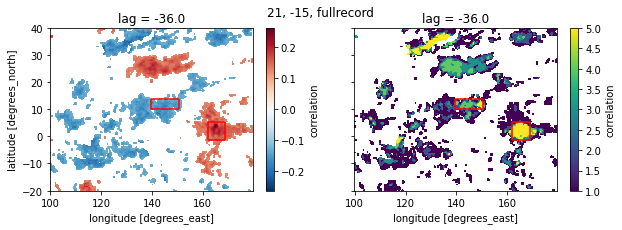

In [18]:
latslice = slice(-20,40)
lonslice = slice(100,180)
fig, axes = plt.subplots(ncols = 2, sharex = True, sharey = True, figsize = (10,3))

fig.suptitle(f'{timeagg}, {separation}, {which}')
meancor = corrpattern.mean('fold')
meancor['correlation'].sel(lag = -(abs(separation) + timeagg), latitude = latslice, longitude = lonslice).plot(ax = axes[0])

nfolds = (~corrpattern.isnull()).sum('fold')
nfolds = nfolds.where(nfolds!=0, np.nan)
nfolds['correlation'].sel(lag = -(abs(separation) + timeagg), latitude = latslice, longitude = lonslice).plot(ax = axes[1])
axes[1].set_ylabel('')

for ax in axes:
    for region in whichregion.index:
        coords = whichregion.loc[region,:]
        ax.hlines(y = coords['latrange'].start, xmin = coords['lonrange'].start, xmax = coords['lonrange'].stop, color = 'red')
        ax.hlines(y = coords['latrange'].stop, xmin = coords['lonrange'].start, xmax = coords['lonrange'].stop, color = 'red')
        ax.vlines(x = coords['lonrange'].start, ymin = coords['latrange'].start, ymax = coords['latrange'].stop, color = 'red')
        ax.vlines(x = coords['lonrange'].stop, ymin = coords['latrange'].start, ymax = coords['latrange'].stop, color = 'red')

In [8]:
index = makeindex2(deseason = True, remove_interannual=False, timeagg = 21, degree = 7).to_pandas()
index.name = 'w_pacif_dipole'

In [9]:
nino_m = pd.read_hdf('~/paper4/nino_rel_monthly.h5')
nino_m.index = pd.date_range(nino_m.index.values.min(), nino_m.index.values.max(), freq = 'MS') # Error with MS freq
nino_m.columns = pd.Index([f'nino_{i}' for i in nino_m.columns.get_level_values('clustid')],name = 'var')
nino_d = interpolate(nino_m)
pdo_m = pd.read_hdf('~/paper4/pdo_monthly.h5')
pdo_d = interpolate(pdo_m)
mjo_d = pd.read_hdf('~/paper4/mjo_daily.h5').loc[(slice(None),0),:].iloc[:,-1]
mjo_d.index = mjo_d.index.droplevel('separation')
mjo_d.name = 'MJO_rmm2'

In [160]:
indices = pd.merge(nino_d, pdo_d, how = 'outer', left_index = True, right_index = True).join(mjo_d, how = 'left').join(index, how = 'left')
indices = select_months(indices.reindex(index = index.index), [6,7,8])
indices_1979 = indices.dropna() # indices.drop('MJO_rmm2', axis = 1).dropna()
crosscor_1979 = pd.DataFrame(np.corrcoef(indices_1979.T), index = indices_1979.columns, columns = indices_1979.columns)

In [166]:
selection = ['w_pacif_dipole','nino_3', 'nino_4','PDO']

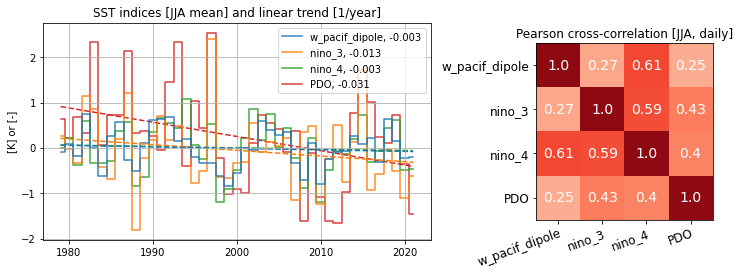

In [170]:
fig = plt.figure(figsize=(12,4),facecolor='white')

gs = GridSpec(nrows = 4, ncols=10, wspace=1, hspace = 0.4)
ax1 = fig.add_subplot(gs[:,:-4])
ax2 = fig.add_subplot(gs[:,-3:])

for zorder, key in enumerate(selection):
    smean = indices_1979.loc[:,key].groupby(indices_1979.index.year).mean()
    linreg = LinearRegression(normalize = False)
    linreg.fit(X = indices_1979.index.year.values[:,np.newaxis], y = indices_1979.loc[:,key])
    l1 = ax1.step(smean.index, smean.values,
                  label = f'{key}, {float(np.round(linreg.coef_,3))}',
                  where = 'mid', alpha = 0.9, zorder = -zorder)
    ax1.plot(smean.index,linreg.predict(X = smean.index.values[:,np.newaxis]), 
            color = l1[0].get_color(), ls = '--', zorder = -zorder + 1)
#ax1.set_ylim((-2,2.5))
#ax1.hlines(0, xmin = smean.index.min(), xmax = smean.index.max(), color = 'black', zorder = -5)
ax1.legend()
ax1.grid(zorder = -7)
ax1.set_title('SST indices [JJA mean] and linear trend [1/year]')
ax1.set_ylabel('[K] or [-]')

im = ax2.imshow(crosscor_1979.loc[selection,selection].values, vmin = -0.1, vmax = 1.1, 
                cmap = 'Reds')#, aspect = 'auto')

# Show all ticks and label them with the respective list entries
ax2.set_xticks(np.arange(len(selection)))
ax2.set_xticklabels(selection, size = 12)
ax2.set_yticks(np.arange(len(selection)))
ax2.set_yticklabels(selection, size = 12)
ax2.set_title('Pearson cross-correlation [JJA, daily]')

plt.setp(ax2.get_xticklabels(), rotation=20, ha="right",
         rotation_mode="anchor")

for i, var1 in enumerate(selection):
    for j, var2 in enumerate(selection):
        ax2.text(j,i,str(np.round(crosscor_1979.loc[var1,var2],2)), 
                 horizontalalignment='center',verticalalignment='center',size = 14, color = 'white')

### T2m predictand, spatially & through time

In [136]:
subdomainlats = slice(40,56)
subdomainlons = slice(-5,24)
clusterfield = xr.open_dataarray('/scistor/ivm/jsn295/clusters/t2m-q095.nc').sel(nclusters = 15, latitude = subdomainlats, longitude = subdomainlons)
reduced = create_response(respagg = 31, degree = 7)

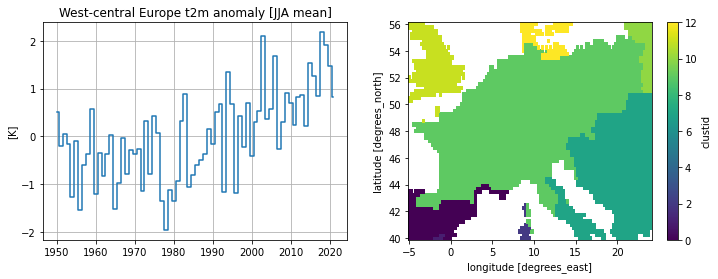

In [153]:
fig, axes = plt.subplots(ncols = 2, figsize = (12,4))
summer = select_months(reduced.to_pandas(), months = [6,7,8])
summermean = summer.groupby(summer.index.year).mean()
axes[0].step(summermean.index, summermean.values, where = 'mid')
axes[0].grid(True)
axes[0].set_ylabel('[K]')
axes[0].set_title('West-central Europe t2m anomaly [JJA mean]')

clusterfield.drop('nclusters').plot(ax = axes[1])

### Combination through time

In [248]:
combined = combine_index_response(idx = index, idxname = '21d_west_pacific_dipole', response = reduced,
                                  lag = True, separation = -15, only_months = [6,7,8], detrend_response = False)

lagging, agg: 21, sep: -15


In [289]:
quantiles = [0.33,0.66]
overall_thresholds = combined.quantile(quantiles)
overall = count_combinations(digitized_array=digitize(combined, thresholds=overall_thresholds))

In [298]:
nyearslice = 21

centeryears = combined.index.year.unique().sort_values()[(nyearslice//2):-(nyearslice//2)]
counts = pd.DataFrame(np.nan, index = centeryears, columns = overall.stack(0).index)

for centeryear in centeryears:
    sl = slice(pd.Timestamp(f'{centeryear - nyearslice//2}-01-01'),pd.Timestamp(f'{centeryear + nyearslice//2}-12-31'))
    comb = combined.loc[sl,:] # combined contains only summer values.
    #thresholds = comb.quantile(quantiles)
    #thresholds = overall_thresholds
    thresholds = overall_thresholds.copy()
    thresholds.loc[:,'t2m-mean-anom'] = comb.quantile(quantiles).loc[:,'t2m-mean-anom'] # replacing only the t2m threshold
    exceedences = digitize(comb, thresholds=thresholds)
    count = count_combinations(digitized_array=exceedences)
    counts.loc[centeryear,:] = count.stack(0)

insync = ['sync'] + ['unsync'] * (counts.shape[-1]-2) + ['sync']
counts.columns = pd.MultiIndex.from_frame(counts.columns.to_frame().assign(diagonal = insync))

In [323]:
# Construct matrix uncertainty band. Sampling full seasons
# Thresholding here does not take into account the narrowing of the t2m range.
nrepeats = 100
samples = pd.DataFrame(np.nan, index = pd.RangeIndex(nrepeats), columns = counts.columns)
for i in range(nrepeats):
    sampled_years = np.random.randint(low = combined.index.year.min(), high = combined.index.year.max() + 1, size = nyearslice)
    draw = combined.loc[combined.index.year.map(lambda y: y in sampled_years),:]
    dummy_matrix = count_combinations(digitize(draw,thresholds = draw.quantile(quantiles)))
    samples.iloc[i,:] = dummy_matrix.stack(0)

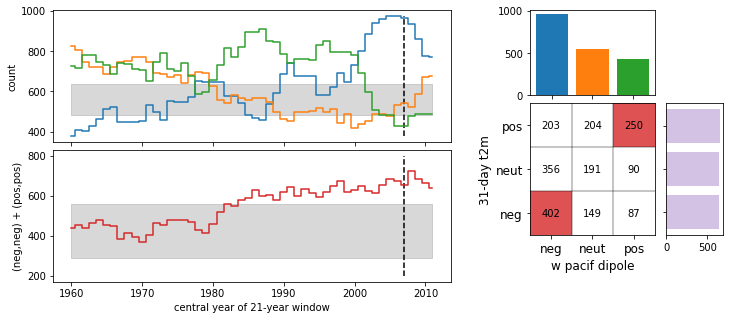

In [436]:
aliases = {0:'neg',1:'neut',2:'pos'}
example_year = 2007
boundaries = [0.025, 0.975]
fig = plt.figure(figsize=(12,5),facecolor='white')

gs = GridSpec(nrows = 6, ncols=10, wspace=0.2, hspace = 0.2)
axw = fig.add_subplot(gs[:3,:6])
axt = fig.add_subplot(gs[3:,:6])
axm = fig.add_subplot(gs[2:-1,7:-1])
axmv = fig.add_subplot(gs[:2,7:-1])
axmh = fig.add_subplot(gs[2:-1,-1:])

# West pacific plot
wpacif = counts.groupby('w_pacif_dipole', axis = 1).sum()
wpacif_bounds = samples.groupby('w_pacif_dipole', axis = 1).sum().stack().quantile(boundaries) # This assumes equal sample range. 
colors = []
for i, alias in aliases.items():
    lw = axw.step(wpacif.index, wpacif[i], label = alias, where = 'mid')
    colors.append(lw[0].get_color())
axw.fill_between(wpacif.index, y1 = wpacif_bounds.iloc[0], y2 = wpacif_bounds.iloc[1], color = 'grey', alpha = 0.3)
axw.vlines(x = example_year, ymin = wpacif.min(), ymax = wpacif.max(), ls = '--')
axw.set_xticklabels('')
axw.set_ylabel('count')

# synchronized entries
sync = counts.groupby('diagonal', axis = 1).sum()['sync']
sync_bounds = samples.groupby('diagonal', axis = 1).sum().quantile(boundaries)['sync']
axt.step(sync.index, sync.values, color = 'tab:red', where = 'mid')
axt.fill_between(sync.index, y1 = sync_bounds.iloc[0], y2 = sync_bounds.iloc[1], color = 'grey', alpha = 0.3)
axt.vlines(x = example_year, ymin = 200, ymax = 800, ls = '--')
axt.set_xlabel(f'central year of {nyearslice}-year window')
axt.set_ylabel(f'({aliases[0]},{aliases[0]}) + ({aliases[2]},{aliases[2]})')

# Example plot matrix
for sst, t2m, key in counts.columns:
    val = counts.loc[example_year,(sst,t2m)]
    if key == 'sync':
        axm.barh(width = 1, height = 1, left = sst-0.5, y = t2m, align = 'center', color = 'tab:red', alpha = 0.8)
    axm.text(x = sst, y = t2m, s = int(val),horizontalalignment='center', verticalalignment='center', color = 'black')
axm.vlines(x = [0.5,1.5], ymin = -0.5, ymax = 2.5, alpha = 0.3)
axm.hlines(y = [0.5,1.5], xmin = -0.5, xmax = 2.5, alpha = 0.3)
axm.set_xlim((-0.5,2.5))
axm.set_ylim((-0.5,2.5))

axm.set_xticks(list(aliases.keys()))
axm.set_xticklabels(list(aliases.values()), size = 12)
axm.set_xlabel('w pacif dipole', size = 12)

axm.set_yticks(list(aliases.keys()))
axm.set_yticklabels(list(aliases.values()), size = 12)
axm.set_ylabel('31-day t2m', size = 12)


# Example plot vertical
axmv.bar(wpacif.loc[example_year,:].index, wpacif.loc[example_year,:], color = colors)
axmv.set_xticklabels('')

# Example plot horizontal
t2m_counts = counts.groupby('t2m-mean-anom', axis = 1).sum()
axmh.barh(y = t2m_counts.columns, width = t2m_counts.loc[example_year], color = 'tab:purple', alpha = 0.4)
axmh.set_yticklabels('')

plt.show()

### Composites of the wave pattern
contrasting pos,pos with neg, neg